#Import Library Kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yourbeagle","key":"f02c85b9e7db1548472d4345258abe36"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d hernan4444/anime-recommendation-database-2020 -p /content/sample_data/ --unzip

100% 658M/661M [00:22<00:00, 29.3MB/s]
100% 661M/661M [00:23<00:00, 30.1MB/s]


#Import Library yang dibutuhkan

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import seaborn as sns
import re
import textwrap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras

#Read Dataset

In [6]:
anime_data = pd.read_csv('/content/sample_data/anime.csv')
anime_data.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


#Exploratory Data Analysis

In [7]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

**Membuang Variabel yang tidak memiliki korelasi**

In [8]:
anime_data = anime_data.drop(['English name','Japanese name', 'Aired', 'Premiered', 'Licensors', 'Duration', 'Watching', 
                              'Completed', 'On-Hold', 'Dropped', 'Plan to Watch','Score-10','Score-9','Score-8',
                              'Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1'], axis=1)
anime_data.head()

,MAL_ID,Name,Score,Genres,Type,Episodes,Producers,Studios,Source,Rating,Ranked,Popularity,Members,Favorites
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,Bandai Visual,Sunrise,Original,R - 17+ (violence & profanity),28.0,39,1251960,61971
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,"Sunrise, Bandai Visual",Bones,Original,R - 17+ (violence & profanity),159.0,518,273145,1174
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26,Victor Entertainment,Madhouse,Manga,PG-13 - Teens 13 or older,266.0,201,558913,12944
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,PG-13 - Teens 13 or older,2481.0,1467,94683,587
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52,"TV Tokyo, Dentsu",Toei Animation,Manga,PG - Children,3710.0,4369,13224,18


**Deskripsi Setiap Variabel**

In [9]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MAL_ID      17562 non-null  int64 
 1   Name        17562 non-null  object
 2   Score       17562 non-null  object
 3   Genres      17562 non-null  object
 4   Type        17562 non-null  object
 5   Episodes    17562 non-null  object
 6   Producers   17562 non-null  object
 7   Studios     17562 non-null  object
 8   Source      17562 non-null  object
 9   Rating      17562 non-null  object
 10  Ranked      17562 non-null  object
 11  Popularity  17562 non-null  int64 
 12  Members     17562 non-null  int64 
 13  Favorites   17562 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 1.9+ MB




1.   MAL_ID - kode unik untuk mengindentifikasi setiap anime
2.   Name - judul dari anime
3.   Score - Rata-rata skor yang diberikan oleh user MAL
4.   Genres - Genre dari anime
5.   Episodes - Jumlah episode dari anime (1, jika movie atau spesial episode)
6.   Producers - Producer yang membuat anime
7.   Studios - Studio yang menggarap anime
8.   Source - Sumber dari cerita anime
9.   Rating - Rating dari anime
10.  Ranked - Peringkat dari anime berdasarkan nilai skor
11.  Popularity - Peringkat dari anime berdasarkan user menambahkan ke watchlist
12.  Members - jumlah anggota komunitas yang ada di "grup" anime
13.  Favorites - jumlah anggota komunitas yang menambahkan anime kedalam daftar favorit mereka



#Missing Value

In [10]:
print("Data Yang \t => \t Kolom")
print("Memiliki")
print("Nilai Null")
print("=======================")
for i in anime_data.columns:
    print((anime_data[i].isna()).sum(), "\t => \t" + i) 

Data Yang 	 => 	 Kolom
Memiliki
Nilai Null
0 	 => 	MAL_ID
0 	 => 	Name
0 	 => 	Score
0 	 => 	Genres
0 	 => 	Type
0 	 => 	Episodes
0 	 => 	Producers
0 	 => 	Studios
0 	 => 	Source
0 	 => 	Rating
0 	 => 	Ranked
0 	 => 	Popularity
0 	 => 	Members
0 	 => 	Favorites


In [11]:
anime_data.shape

(17562, 14)

Mengubah nilai Unknown pada Kolom Score dengan nilai 0

In [12]:
anime_data['Score'] = anime_data['Score'].replace(['Unknown'],0)

In [13]:
anime_data.shape

(17562, 14)

Mengubah tipe data Score menjadi float

In [14]:
anime_data['Score'] = anime_data['Score'].astype('float')

#Univariate Data Analysis

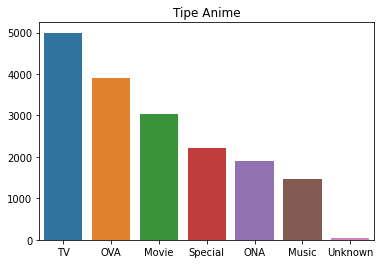

In [15]:
anime_tipe = anime_data['Type'].value_counts()
sns.barplot(y=anime_tipe.values,
            x=anime_tipe.index,).set_title("Tipe Anime")
plt.show()

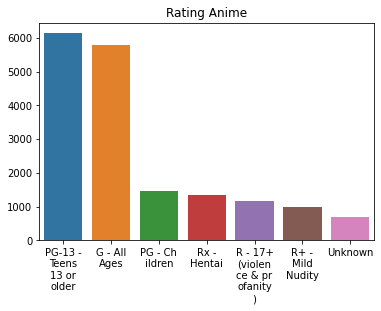

In [16]:
anime_rating = anime_data['Rating'].value_counts()
sns.barplot(y=anime_rating.values,
            x=[textwrap.fill(e, 7) for e in anime_rating.index]).set_title("Rating Anime")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


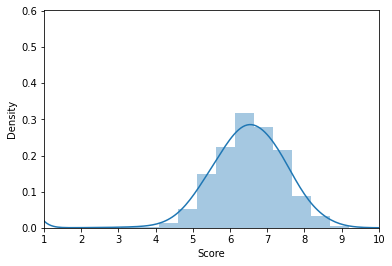

In [17]:
fig, ax = plt.subplots()
sns.distplot(anime_data['Score'], ax = ax)
ax.set_xlim(1, 10)
plt.show()

In [18]:
anime_producers_count=anime_data['Producers'].value_counts().sort_values(ascending=False)
anime_producers_count=pd.DataFrame(anime_producers_count)
topProducers=anime_producers_count[1:11]
topProducers

,Producers
NHK,623
Pink Pineapple,184
Sanrio,160
Bandai Visual,117
Fuji TV,112
Aniplex,105
TV Tokyo,102
Gakken,89
TV Asahi,86
Tokyo Movie Shinsha,75


In [19]:
anime_studios_count=anime_data['Studios'].value_counts().sort_values(ascending=False)
anime_studios_count=pd.DataFrame(anime_studios_count)
topStudios=anime_studios_count[1:11]
topStudios

,Studios
Toei Animation,755
Sunrise,479
J.C.Staff,358
Madhouse,324
TMS Entertainment,277
Production I.G,266
Studio Deen,263
Studio Pierrot,249
OLM,212
Nippon Animation,208


#Multivariate Analysis

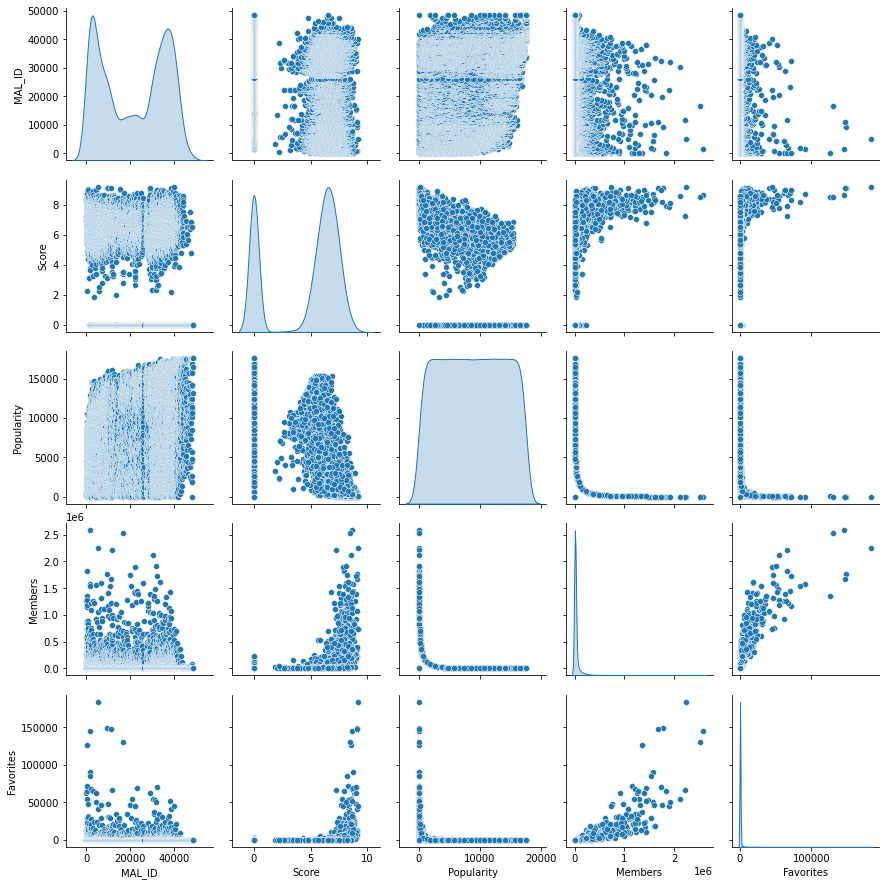

In [20]:
sns.pairplot(anime_data, diag_kind = 'kde')

#Text Cleaning

In [21]:
anime_data['Name'].unique()[5:15]

array(['Eyeshield 21', 'Hachimitsu to Clover',
       'Hungry Heart: Wild Striker', 'Initial D Fourth Stage', 'Monster',
       'Naruto', 'One Piece', 'Tennis no Ouji-sama', 'Ring ni Kakero 1',
       'School Rumble'], dtype=object)

In [22]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [23]:
def textCleaning(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
    x = x.strip()

    return x

In [24]:
anime_data['Name'] = anime_data['Name'].apply(textCleaning)

In [25]:
anime_data['Name'].unique()[0:15]

array(['cowboy bebop', 'cowboy bebop  tengoku no tobira', 'trigun',
       'witch hunter robin', 'bouken ou beet', 'eyeshield 21',
       'hachimitsu to clover', 'hungry heart  wild striker',
       'initial d fourth stage', 'monster', 'naruto', 'one piece',
       'tennis no ouji sama', 'ring ni kakero 1', 'school rumble'],
      dtype=object)

#Model Development with Content Based Filtering

Disini saya menggunakan **TF-IDF Vectorizer** sebagai model yang digunakan untuk menemukan representasi fitur penting dari setiap genre anime

In [26]:
anime_id = anime_data['MAL_ID'].tolist()
anime_name = anime_data['Name'].tolist()
anime_genres = anime_data['Genres'].tolist()

print(len(anime_id))
print(len(anime_name))
print(len(anime_genres))

17562
17562
17562


In [27]:
anime_data_new = pd.DataFrame({
    'animeID': anime_id,
    'animeName': anime_name,
    'animeGenre': anime_genres
})
anime_data_new

,animeID,animeName,animeGenre
0,1,cowboy bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,cowboy bebop tengoku no tobira,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,7,witch hunter robin,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,bouken ou beet,"Adventure, Fantasy, Shounen, Supernatural"
...,...,...,...
17557,48481,daomu biji zhi qinling shen shu,"Adventure, Mystery, Supernatural"
17558,48483,mieruko chan,"Comedy, Horror, Supernatural"
17559,48488,higurashi no naku koro ni sotsu,"Mystery, Dementia, Horror, Psychological, Supe..."
17560,48491,yama no susume next summit,"Adventure, Slice of Life, Comedy"


In [28]:
data = anime_data_new
data.sample(5)

,animeID,animeName,animeGenre
1616,1777,kaze no tairiku,"Action, Adventure, Fantasy, Supernatural"
4472,6130,marie & gali,Comedy
13994,37007,hinomaruzumou,"Martial Arts, Shounen, Sports"
12364,34337,ikemen sengoku toki wo kakeru ga koi wa hajim...,"Historical, Romance"
429,458,buttobi ! ! cpu,"Comedy, Ecchi, Magic, Sci-Fi, Seinen"


In [29]:
tf = TfidfVectorizer()
tf.fit(data['animeGenre'])
tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'of',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'unknown',
 'vampire',
 'yaoi',
 'yuri']

In [30]:
tfidf_matrix = tf.fit_transform(data['animeGenre'])
tfidf_matrix.shape 

(17562, 48)

In [31]:
tfidf_matrix.todense()

matrix([[0.31199952, 0.3460455 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29954579, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.34287632, 0.38029163, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.42391504, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.68376358, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [32]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.animeName
).sample(22, axis=1).sample(10, axis=0)

,life,sci,of,sports,adventure,yaoi,comedy,mystery,fantasy,cars,...,music,demons,drama,josei,unknown,mecha,power,magic,game,arts
animeName,,,,,,,,,,,,,,,,,,,,,
kodomo no jikan recap,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.361891,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
wake up girl zoo ! taiwan de go !,0.000000,0.000000,0.000000,0.0,0.00000,0.0,1.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
little twins bokura no natsu ga tondeiku,0.000000,0.000000,0.000000,0.0,0.69402,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
yoligongju loopy,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.795442,0.000000,0.0
ichigeki sacchuu ! ! hoihoi san,0.444616,0.403194,0.444616,0.0,0.00000,0.0,0.286041,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
sore ike ! zukkoke sannin gumi,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.422718,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
warau salesman tokubetsu bangumi,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
anne no nikki anne frank monogatari,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.6141,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
to love ru multiplication mae kara ushiro kara,0.000000,0.302898,0.000000,0.0,0.00000,0.0,0.214888,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [33]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.78149159, 0.74413675, ..., 0.        , 0.22787653,
        0.21333391],
       [0.78149159, 1.        , 0.51816708, ..., 0.18292702, 0.        ,
        0.2048185 ],
       [0.74413675, 0.51816708, 1.        , ..., 0.        , 0.25042816,
        0.23444634],
       ...,
       [0.        , 0.18292702, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.22787653, 0.        , 0.25042816, ..., 0.        , 1.        ,
        0.        ],
       [0.21333391, 0.2048185 , 0.23444634, ..., 0.        , 0.        ,
        1.        ]])

In [34]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['animeName'], columns=data['animeName'])
print('Shape:', cosine_sim_df.shape)

Shape: (17562, 17562)


In [35]:
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

animeName,just awake,super robot taisen og divine wars,makura no danshi,spheres,kaichou wa maid sama !
animeName,,,,,
mobile suit gundam san hiyoko days suisei hiyoko to fushigi na ofuda,0.000000,0.382313,0.0,0.000000,0.107420
milkyway,0.000000,0.000000,0.0,0.000000,0.329091
no 6,0.581230,0.542287,0.0,0.125716,0.000000
junai maniac,0.000000,0.000000,0.0,0.000000,0.000000
cosmic break,0.000000,0.342648,0.0,0.000000,0.000000
persona 2 another self,0.161807,0.150965,0.0,0.277360,0.000000
kogepan,0.000000,0.000000,0.0,0.000000,0.314951
spice paradise curry meshi ver,0.535053,0.000000,0.0,0.000000,0.000000
yoru ga kuru !,0.000000,0.000000,0.0,0.513108,0.000000


Di sini, kita membuat fungsi get_anime_recommendations dengan beberapa parameter sebagai berikut:

1.   anime_name : Nama Anime (index kemiripan dataframe).
2.   Similarity_data : Dataframe mengenai similarity yang telah kita definisikan sebelumnya.
3.   Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘animeID’, ‘animeName’, dan ‘animeGenre’.
4.   k : Banyak rekomendasi yang ingin diberikan.



In [36]:
def get_anime_recommendations(anime_name, similarity_data=cosine_sim_df, items=data[['animeID', 'animeName', 'animeGenre']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,anime_name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(anime_name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

#Evaluasi

Untuk mengevaluasi model saya melakukan uji coba langsung dengan memanggil fungsi yang sudah saya buat dan memasukan judul anime yang pengguna suka sebelumnya.

In [37]:
data[data.animeName.eq('inuyasha')]

,animeID,animeName,animeGenre
225,249,inuyasha,"Action, Adventure, Comedy, Historical, Demons,..."


In [38]:
get_anime_recommendations('inuyasha')

,animeName,animeID,animeGenre
0,inuyasha kanketsu hen,6811,"Action, Adventure, Comedy, Historical, Demons,..."
1,inuyasha movie 2 kagami no naka no mugenjo,450,"Action, Adventure, Comedy, Historical, Demons,..."
2,inuyasha movie 3 tenka hadou no ken,451,"Action, Adventure, Comedy, Historical, Demons,..."
3,inuyasha movie 4 guren no houraijima,449,"Action, Adventure, Comedy, Historical, Demons,..."
4,inuyasha movie 1 toki wo koeru omoi,452,"Action, Adventure, Comedy, Historical, Demons,..."
5,hanyou no yashahime sengoku otogizoushi,41911,"Action, Adventure, Comedy, Historical, Demons,..."
6,inuyasha kuroi tessaiga,4886,"Adventure, Comedy, Demons, Supernatural, Magic..."
7,slayers excellent,1171,"Adventure, Comedy, Demons, Supernatural, Magic..."
8,chrno crusade,60,"Action, Demons, Historical, Romance, Shounen, ..."
9,kagee grimm douwa,10236,"Kids, Adventure, Fantasy, Magic, Romance, Supe..."


Kita copy hasil dari fungsi get_anime_recommendations dengan input inuyasha kedalam variabel genre_recom

In [42]:
genre_recom = get_anime_recommendations('inuyasha')

Kita copy value dari datafram anime dengan nama inuyasha kedalam variabel genre_exp sebagai patokan kita untuk mencocokkan dengan genre yang di rekomendasikan fungsi 

In [43]:
genre_exp = anime_data[anime_data['Name'] == 'inuyasha']

In [44]:
genre_exp

,MAL_ID,Name,Score,Genres,Type,Episodes,Producers,Studios,Source,Rating,Ranked,Popularity,Members,Favorites
225,249,inuyasha,7.85,"Action, Adventure, Comedy, Historical, Demons,...",TV,167,"Yomiuri Telecasting, Shogakukan",Sunrise,Manga,PG-13 - Teens 13 or older,740.0,187,588434,17186


Memisah genre yang ada di varibel genre_exp kedalam array baru

In [49]:
get_recom_genre=[]
for i in range(len(genre_exp.Genres)):
    for x in genre_exp.Genres.str.split(','):
        if x not in get_recom_genre:
            get_recom_genre.append(x)

Melihat akurasi pada genre yang direkomendasikan, dapat dilihat anime yang direkomendasikan oleh fungsi memiliki nilai 100% akurasi pada setiap genre

In [58]:
for i in get_recom_genre[0]:
  print(i + ": " + str((
      (genre_recom['animeGenre'].str.contains(i).count()/genre_recom['animeGenre'].count())*100)
  ))

Action: 100.0
 Adventure: 100.0
 Comedy: 100.0
 Historical: 100.0
 Demons: 100.0
 Supernatural: 100.0
 Magic: 100.0
 Romance: 100.0
 Fantasy: 100.0
 Shounen: 100.0


In [39]:
get_anime_recommendations('naruto')

,animeName,animeID,animeGenre
0,boruto jump festa 2016 special,35072,"Action, Adventure, Comedy, Super Power, Martia..."
1,naruto shippuuden,1735,"Action, Adventure, Comedy, Super Power, Martia..."
2,rekka no honoo,238,"Action, Adventure, Martial Arts, Shounen, Supe..."
3,naruto shippuuden movie 6 road to ninja,13667,"Action, Adventure, Super Power, Martial Arts, ..."
4,naruto honoo no chuunin shiken ! naruto vs ...,10686,"Action, Adventure, Martial Arts, Shounen, Supe..."
5,boruto naruto next generations,34566,"Action, Adventure, Super Power, Martial Arts, ..."
6,dragon ball kai,6033,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
7,dragon ball z movie 11 super senshi gekiha ! ...,904,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
8,dragon ball z atsumare ! gokuu world,6714,"Action, Adventure, Comedy, Super Power, Martia..."
9,dragon ball z movie 15 fukkatsu no f,25389,"Action, Adventure, Comedy, Super Power, Martia..."


In [40]:
get_anime_recommendations('overlord')

,animeName,animeID,animeGenre
0,overlord ii,35073,"Action, Game, Adventure, Supernatural, Magic, ..."
1,overlord movie 1 fushisha no ou,34161,"Action, Game, Supernatural, Magic, Fantasy"
2,overlord movie 2 shikkoku no eiyuu,34428,"Action, Game, Supernatural, Magic, Fantasy"
3,overlord iii,37675,"Action, Magic, Fantasy, Game, Supernatural"
4,ku pao ying xiong,36440,"Action, Adventure, Fantasy, Game, Magic"
5,log horizon entaku houkai,41109,"Action, Game, Adventure, Magic, Fantasy"
6,log horizon 2nd season,23321,"Action, Game, Adventure, Magic, Fantasy"
7,log horizon,17265,"Action, Game, Adventure, Magic, Fantasy"
8,juuni kokuki,153,"Action, Adventure, Fantasy, Magic, Supernatural"
9,legend of crystania,1150,"Action, Adventure, Fantasy, Magic, Supernatural"


In [41]:
get_anime_recommendations('one piece')

,animeName,animeID,animeGenre
0,one piece episode of sorajima,37902,"Action, Adventure, Comedy, Super Power, Drama,..."
1,one piece movie 14 stampede,38234,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,one piece episode of east blue luffy to 4 n...,36215,"Action, Adventure, Comedy, Super Power, Drama,..."
3,one piece episode of sabo 3 kyoudai no kizu...,31289,"Action, Adventure, Comedy, Super Power, Drama,..."
4,one piece episode of nami koukaishi no nami...,15323,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
5,one piece episode of merry mou hitori no na...,19123,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
6,one piece long ring long land hen,32437,"Action, Adventure, Comedy, Super Power, Drama,..."
7,one piece film gold episode 0 711 ver,33606,"Action, Adventure, Comedy, Super Power, Fantas..."
8,one piece movie 3 chinjuu jima no chopper oukoku,461,"Action, Adventure, Comedy, Super Power, Fantas..."
9,one piece movie 5 norowareta seiken,463,"Action, Adventure, Comedy, Super Power, Fantas..."
